Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: MIT-0

#  DAT107 Using vectors with graphs for gen AI apps in Amazon NeptuneAnalytics Workshop

## Table Of Contents
* [Introduction](##Introduction)
* [Creating Neptune Analytics Graph](##Creating-Neptune-Analytics-Graph)
* [The EDGAR Data Model ](##The-EDGAR-Data-Model)
* [Competitive analysis](##Competitive-analysis)
* [Vector Similarity Search + Graph Traversals](##Vector-Similarity-Search-+-Graph-Traversals)
* [Create conversational agent](##Create-conversational-agent)







## Introduction

Vector formats and as contextual graph representations. Amazon Neptune Analytics is a new analytics database engine that lets users combine vector data with graphs 
making it an ideal fit for augmenting Retrieval Augmented Generation (RAG) applications with contextually relevant information. Join us as we live code a sample application demonstrating how to build a RAG application that uses vector similarity search with graph traversals and algorithms using Neptune Analytics. Also explore developments in generative AI by demonstrating graph query generation using LangChain.

## Creating Neptune Analytics Graph

We will start by creating new graph 
with AWS CLI command:
<div class="alert alert-block alert-info"> 
<details>
    <summary>✏️<b><i> Click here for a tip</i></b></summary>
  AWS CLI commands and other OS CLI commands can be run inside the notebook by using the %%bash magic 
</details>
</div>

The following command will create graph of Neptune Analytics

1. [Memory-Optimized Neptune Capacity Units](https://aws.amazon.com/neptune/pricing/) (m-NCU) of 256 m-NCU
2. [Vector search index](https://docs.aws.amazon.com/neptune-analytics/latest/userguide/vector-index.html#:~:text=You%20can%20only%20create%20a,between%201%20and%2065%2C535%20inclusive.) of 384 dimensions

In [ ]:
%%bash
aws neptune-graph create-graph --graph-name 'edgar2' --provisioned-memory 256 --public-connectivity --replica-count 0 --vector-search-configuration '{"dimension": 384}'

This is exsample for output 

```json
{
    "id": "g-ld86y4dpc4",
    "name": "edgar2",
    "arn": "arn:aws:neptune-graph:us-east-1:410769576504:graph/g-ld86y4dpc4",
    "status": "CREATING",
    "createTime": 1715580417.941,
    "provisionedMemory": 128,
    "endpoint": "g-ld86y4dpc4.us-east-1.neptune-graph.amazonaws.com",
    "publicConnectivity": true,
    "vectorSearchConfiguration": {
        "dimension": 384
    },
    "replicaCount": 0,
    "kmsKeyIdentifier": "AWS_OWNED_KEY",
    "deletionProtection": true
}
```

We can also use aws cli to find the new Neptune Analytics graphs


In [ ]:
%%bash 
aws neptune-graph list-graphs



For the next step we need the endpoint of the newly created graph  <br>
In this command example <br>

```json
"endpoint": "g-ld86y4dpc4.us-east-1.neptune-graph.amazonaws.com",
```

We will use notebook magic to update the graph endpoint for this notebook 

Replace the "[New graph endpoint]" with the endpoint name


<div class="alert alert-block alert-info"> 
<details>
    <summary>✏️<b><i> Click here for a tip</i></b></summary>
  
If you need to change the graph that this notebook points to please look at the `%graph_notebook_config` and `%graph_notebook_host` magics, which are described [here](https://github.com/aws/graph-notebook/tree/main).  
</details>
</div>

In [ ]:
%graph_notebook_config

In [ ]:
%%graph_notebook_config 
{
  "host": "[New graph endpoint]",
  "neptune_service": "neptune-graph",
  "port": 8182,
  "auth_mode": "IAM",
  "load_from_s3_arn": "",
  "ssl": true,
  "ssl_verify": true,
  "aws_region": "us-east-1"
}

## The EDGAR Data Model 


Investors and analysts commonly review 13F filings to track the investment activities and holdings of some of the highest profile hedge funds, asset managers, pensions funds, and others required to file. Comparing filings quarter-over-quarter can provide clues to investment themes or sectors that institutions are increasing or decreasing their exposure to. While 13F data does have some limitations, it remains one of the most readily accessible sources of information on where major institutional money is being allocated in U.S. equity markets each quarter.



In this notebook we will be looking at data from the [EDGAR system](https://www.sec.gov/edgar/search-and-access) to demonstrate how to leverage, graphs, graph analytics, and vector similarity to perform investment analysis of stock holdings.


The data used in this notebook was retrieved from EDGAR during the 4th quarter of 2023.  This information is a representative subset of the data for this quarter which we turned into a knowledge graph representing businesses, fiscal quarters, and holdings in those quarters.  The data model used in this example is below:


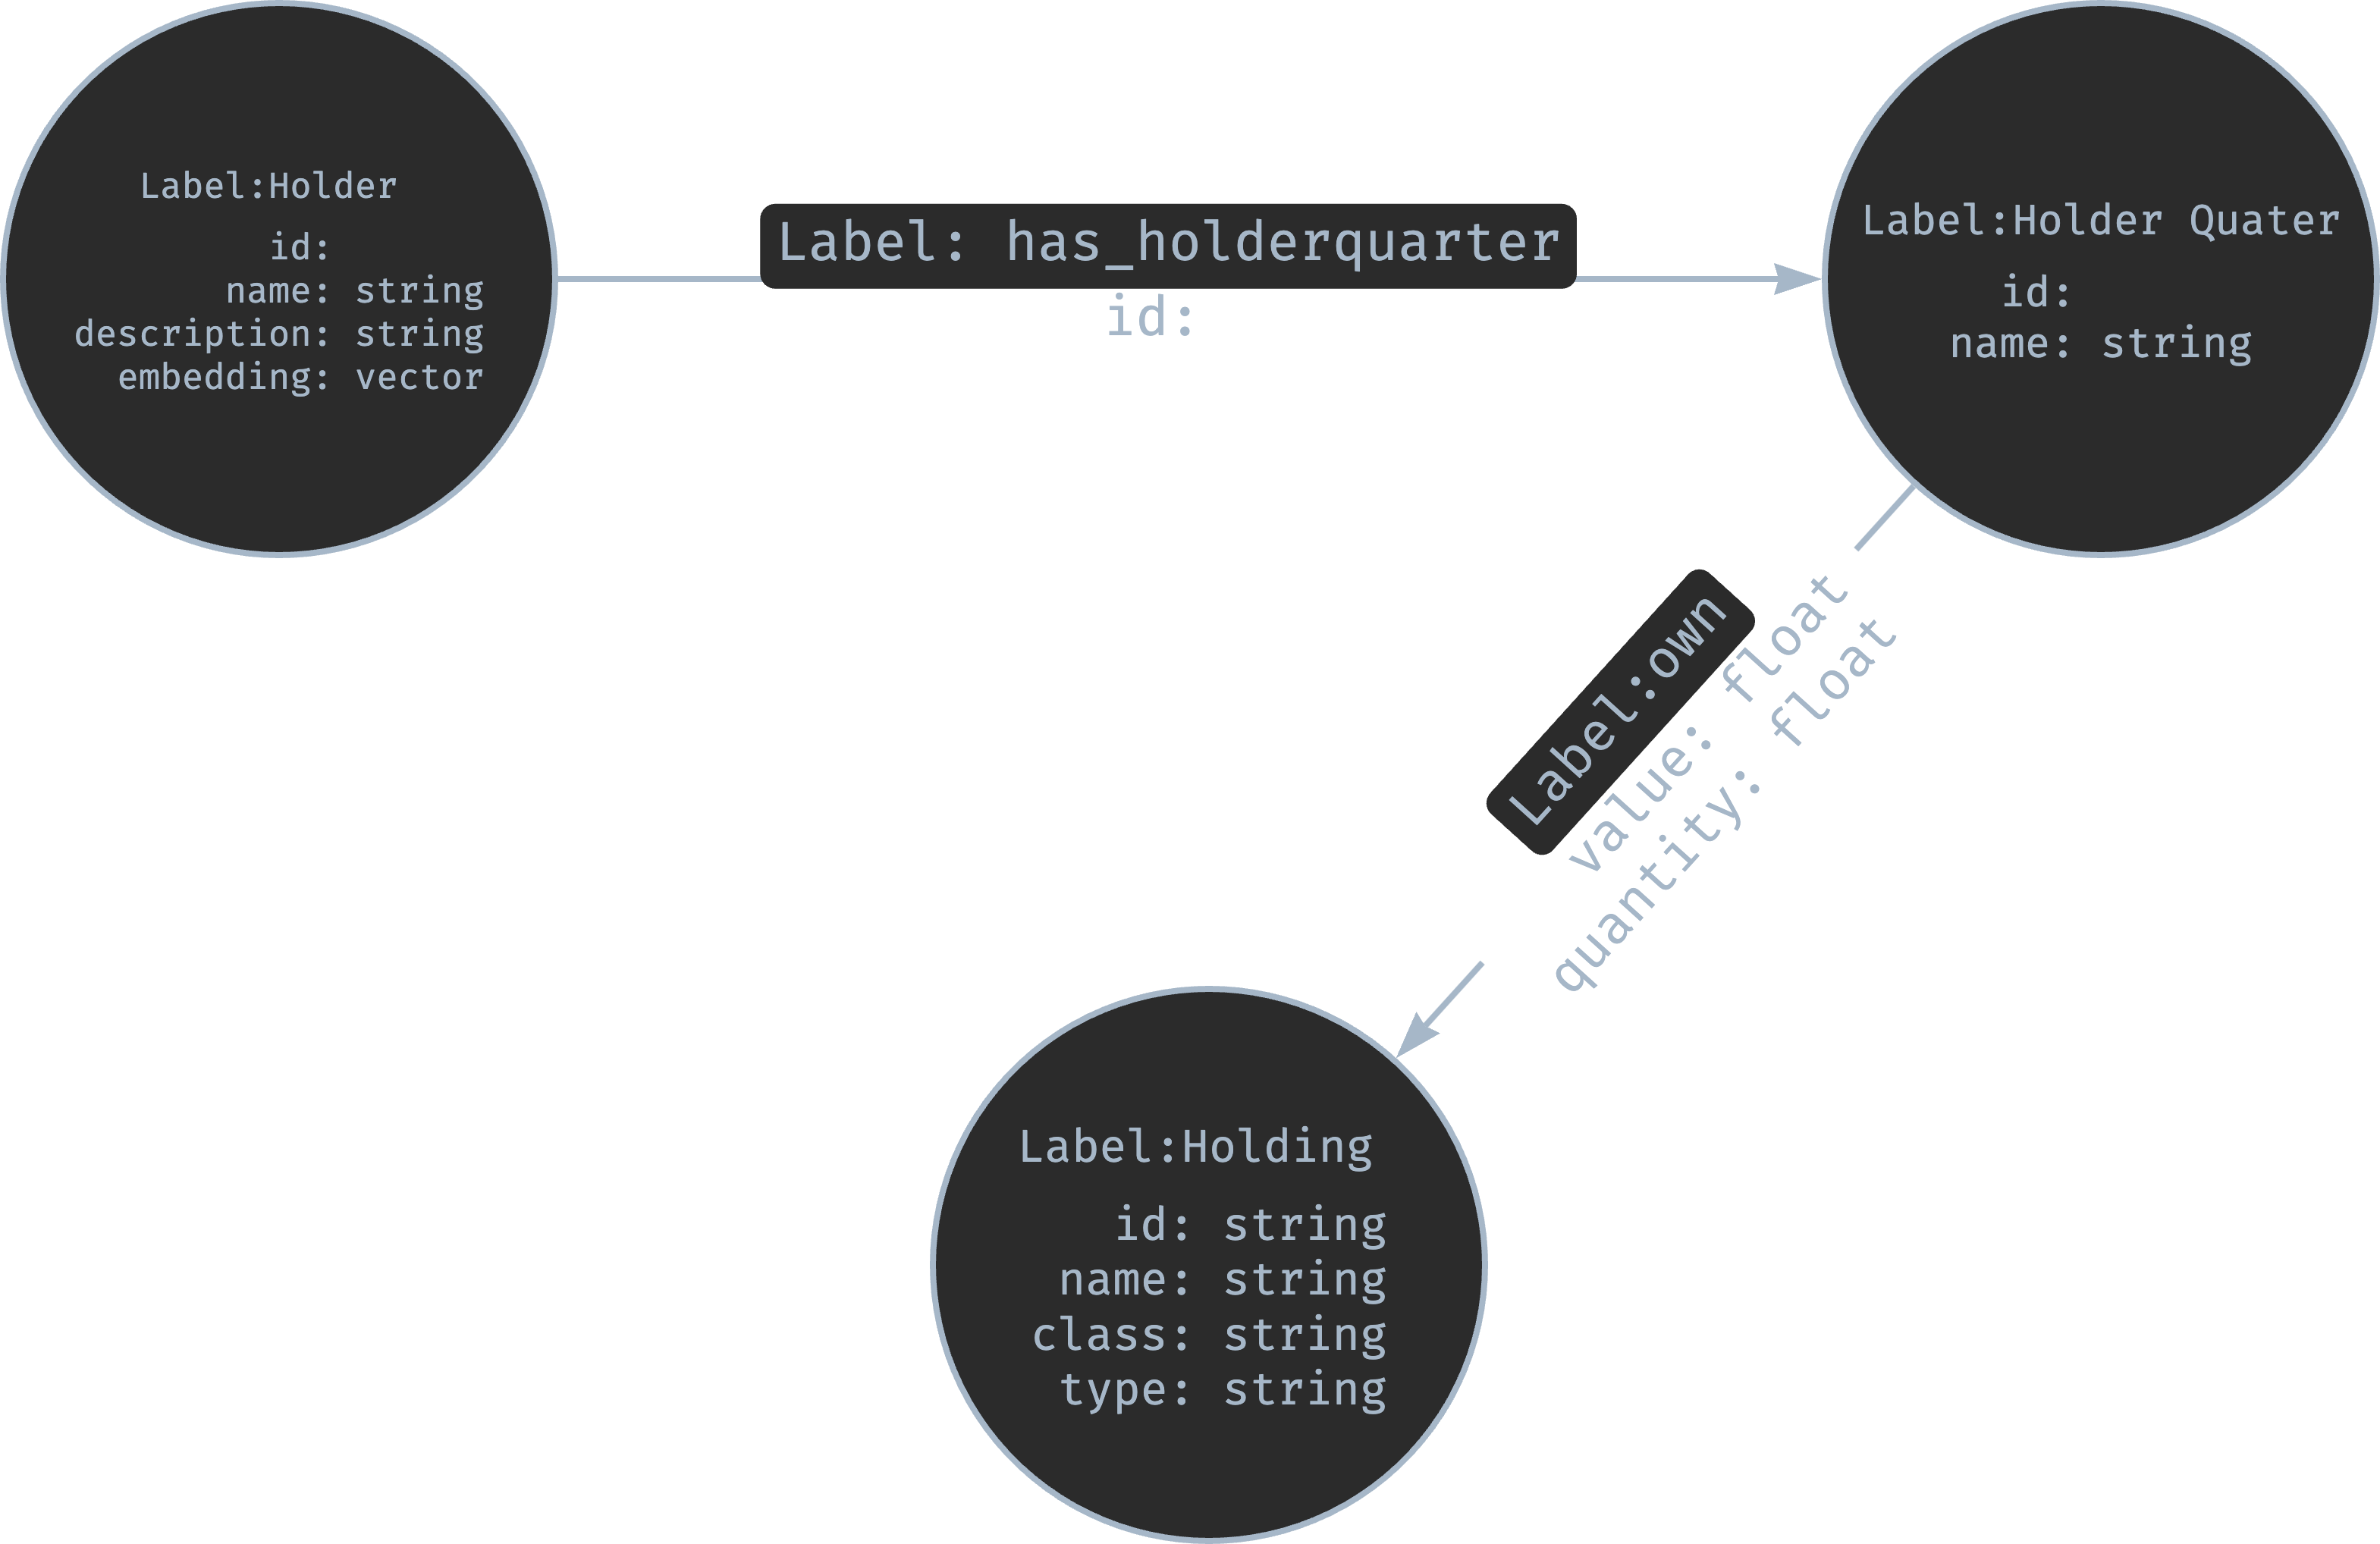

This data model has several key elements:

* `Holder` - This represents the business or entity that is making the filing. The id of the node represents the `CIK` value which is an SEC assigned identified. 
    * Each node contains a `name` and `description` attribute, which was provided by Bedrock from the name.
    * The description attribute was then used to generate a vector embedding of the description.
    * We provide in the next section a demo code for mebeding the string decription  

This image show one recored from the *holder_node_with_embeddings.csv* 
Notice that the description is a *string* data type and the embedding is a *vector* data type


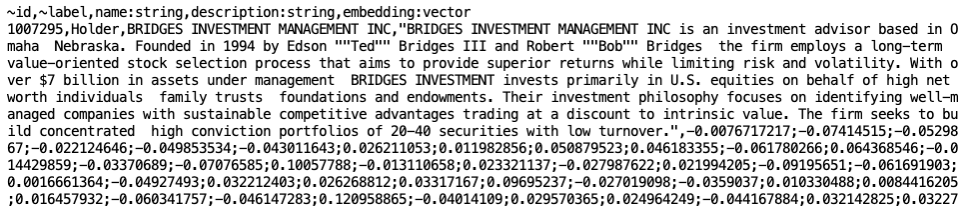


* `HolderQuarter` - This represents the quarter, the name represents the quarter (i.e. `2023Q2`) and the id is a combination of the quarter and id value of the `Holder`.

* `Holding` - This represents the security owned by the `Holder` in the `HolderQuarter`.  This contains a `class`, `type`, and `name` attribute.

* `has_holderquarter` - This represents a fiscal quarter in which the `Holder` had reportable investments.

* `owns` - This represents a security owned by a `Holder` in a `HolderQuarter`.  This contains a `quantity` and `value` attribute, which represents the number and value of the shares owned by the `Holder` in a `HolderQuarter`.


#### ❗ This is a demo code for embedding NO NEED TO RUN THIS CODE ❗
*  Demo code for mebeding the string decription  
```python
import boto3
from langchain.embeddings import BedrockEmbeddings
import pandas as pd
import graph_notebook as gn
config = gn.configuration.get_config.get_config()
# configuring the Embedding Length
embedding_config = {
        "embeddingConfig": { 
             "outputEmbeddingLength": 384
         }
}
# load the csv file
df = pd.read_csv("data/holder_node.csv")
# create boto3 client using local role 
bedrock_client = boto3.client(service_name="bedrock-runtime", region_name="us-east-1")
#create BedrockEmbeddings by using embedding_config
bedrock_embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-image-v1", client=bedrock_client,model_kwargs=embedding_config)
# Embedding line by line where we have lable = movies
for i in df.index:
    if df.loc[i]["~label"] == "Holder":
        json = df.loc[i].to_json()
        embedding = bedrock_embeddings.embed_query(json)
        df.at[i, "embedding:vector"] = (
            str(embedding).replace(", ", ";").replace("[", "").replace("]", "")
        )
    # print progress 
    if i % 1000 == 0:
        print(f"Embedding row {i}")
try:
    # build the csv to load 
    ## workaround:using float_format to fix df conversion from int to float
    df.to_csv("holder_node_with_embeddings.csv", index=False,float_format='%.0f')
except KeyError:
    print('Error within file, please review files')

```

### Import the data

For the next step we need to use Neptune bulk loader to load data from S3.

The load will take 1-2 minutes.



setup a few python variables using the configuration parameters of this Neptune Notebook

In [ ]:
s3_bucket = f"s3://aws-neptune-customer-samples-us-east-1/sample-datasets/gremlin/edgar/"
print(s3_bucket)

<div class="alert alert-block alert-info"> 
<details>
    <summary>✏️<b><i> Click here for a tip about Neptune Batch load</i></b></summary>

For more information about [neptune Batch load](https://docs.aws.amazon.com/neptune-analytics/latest/userguide/batch-load.html)
</details>
</div>


Using the neptune bulk loader we will load the data into the neptune graph

In [ ]:
%%oc
CALL neptune.load({format: "csv", 
                   source: "${s3_bucket}", 
                   region : "${region}"})

## Competitive analysis
Now that we have all our data loaded let's begin by looking at the type of competitive analysis we can perform on this knowledge graph model.

#### Finding Similar Investment Portfolios

For our example here let's investigate how similar the portfolios of the largest investment firms are to one another.  This will allow us to perform a competitive analysis 

To start, let's first find the biggest investors, based on value and store this information into a Python variable `investor` using the `--store-to` flag on the query.  This will allow us to reuse these value in later analysis.

* Find the top 10 companies with the largest holdings

In [ ]:
%%oc --store-to data
MATCH (h:Holder)-->(hq:HolderQuarter)-[o:owns]->(holdings:Holding)
WHERE hq.name = '2023Q4'
RETURN h.name, id(hq) as hq_id, sum(o.value) as total_value 
ORDER BY total_value DESC LIMIT 10

Now that we have retrieved the top 10 companies, let's take a moment to setup a python variable `params` with the id of our top investor and the other 9.  We will use this later on for performing further analysis.

In [ ]:
lst=data['results']
params = {'hq_id': lst[0]['hq_id'], 'competitors': [l['hq_id'] for l in lst[-9:]]}
print(params)

Using the values above we will now be able to pass these in as parameters to our future queries. 
This will not only simplify the queries but it will allow the engine to process them more efficiently.

* Now that we have seen their top investments, let's find all the investments where they have >$1B USD invested.

In [ ]:
%%oc -qp params
MATCH (hq:HolderQuarter)-[o:owns]->(h:Holding)
WHERE id(hq) = $hq_id
AND o.value > 1000000000
RETURN h.name, o.value
ORDER by o.value DESC

#### Compare our top investor against competitors

let's see how their investments compare to those of their top competitors.

To do this we can approach this using two different mechanisms.

First, let's take a look at the overall number of shared `Holding`'s where each investor has invested >$1B USD.

In [ ]:
%%oc -qp params
MATCH (hq:HolderQuarter)-[o:owns]->(h:Holding)
WHERE id(hq) = $hq_id
AND o.value > 1000000000
WITH h
MATCH (h)<-[o:owns]-(co_hq)<--(coholder:Holder)
WHERE id(co_hq) IN $competitors
AND o.value > 1000000000
WITH coholder.name as name, collect(DISTINCT h.name) as coholdings
RETURN name, size(coholdings) as number_shared, coholdings
ORDER BY number_shared DESC

With this information we are able to see the securities where the top investors are co-investing.  Looking at the list we see some common tech stocks, such as Alphabet Inc. and Amazon, but we also notice quite a bit of variability as these competitors are investing significant portions of money in different securities >50% of their portfolio.

Looking at these results, we see that while many of the ten most similar were also top investors.

## Vector Similarity Search + Graph Traversals
Up until now we have been using graph traversals and graph algorithms to perform a comparison of investments based on the information in our knowledge graph.


One additional way to look at competitors is by looking at similar companies, not just similar portfolios.  To accomplish this in Neptune Analytics we can use Vector Similarity to find the most similar companies based on a vector comparison.  In this case our `Holder` nodes each contain a vector **embedding** representing a dense data representation of the company description, as sourced from Amazon Bedrock.  



To accomplish this search we will use Neptune Analytic's native vector index and openCypher query integration.  Let's start similarly to how we started our previous investment analysis, by finding the top 10 most similar `Holder` nodes to our top investor. 



<div class="alert alert-block alert-info"> 
<details>
    <summary>✏️<b><i> Click here for a tip about vector similarity in Neptune Analytics </i></b></summary>

For more information about [vector similarity in Neptune Analytics](https://docs.aws.amazon.com/neptune-analytics/latest/userguide/vector-similarity.html)
</details>
</div>

In [ ]:
%%oc -qp params
MATCH (n:Holder)-->(hq)
WHERE id(hq) = $hq_id
CALL neptune.algo.vectors.topKByNode(n)
YIELD node, score
RETURN node.name

Comparing this against our earlier search for top competitors, we see that there is only a minimal overlap between these results.  Which is to be expected.  Our earlier search found competitors based on the investment portfolio.  This example found competitors based on a company description.  Both options provide valuable competitor analysis, however each defines "similarity" using different facets of the investors.

Let's repeat some of the investigations we did before using our vector based competitors starting with the number of shared holdings >$1B USD.

In [ ]:
%%oc -qp params

MATCH (h:Holder)-->(hq)
WHERE id(hq) = $hq_id
WITH h
CALL neptune.algo.vectors.topKByNode(h)
YIELD node, score
WHERE score > 0
WITH node as coholder LIMIT 10
MATCH (holding)<-[o:owns]-(hq)<--(coholder:Holder)
WHERE hq.name = '2023Q4' AND o.value > 10000000000
WITH coholder.name as name, collect(DISTINCT holding.name) as coholdings
RETURN name, size(coholdings) as number_shared, coholdings
ORDER BY number_shared DESC

As we see from the data above, this is quite a different set of results from what we found by comparing portfolios.  

## Create conversational agent

Now after we finishd using openCypher query integration of the graph , we can try a diffrent metology 
To provide the end user with information about the graph data we can use LLM and langchain to investigate the graph.   

We now will create a **Chat application with Bedrock Claude V3 large language model (LLM)** To Query a Neptune graph using the English Language and return a human readable response 

The application can get as an input a question in English Language convert the question to OpenCypher query running the OpenCypher query and return the result as an English Language answer 


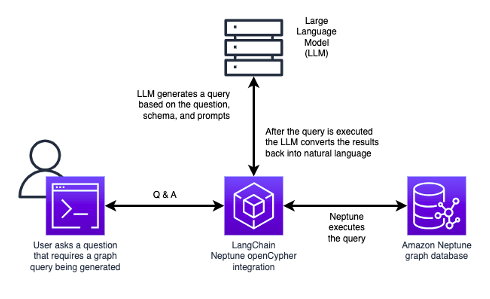



### Prerequisite
This soluation will use 
* Langchain and Bedrock Claude V3 as the LLM 
* Neptune Analytics as the datasource
* Streamlit - open-source Python framework for data scientists and AI/ML as the chatbot user interface 

For this soluation we need to install python packages
The following code will install all the Prerequisite


<div class="alert alert-block alert-info"> 
<details>
    <summary>✏️<b><i> Click here for a tip about streamlit </i></b></summary>

For more information about [streamlit](https://streamlit.io/)
</details>
</div>

In [ ]:
%pip install --no-build-isolation --force-reinstall \
    "boto3>=1.28.57" \
    "awscli>=1.29.57" \
    "botocore>=1.31.57"

In [ ]:
%pip install langchain==0.1.17

In [ ]:
%pip install langchain-community==0.0.36

In [ ]:
%pip install iplantuml

In [ ]:
%pip install langchain-aws

In [ ]:
%pip install streamlit jupyter-server-proxy jupyter-rsession-proxy

#### Use the followin command to verify all installed packages

In [ ]:
%pip show langchain-community langchain langchain-aws streamlit jupyter-server-proxy jupyter-rsession-proxy

```
Name: langchain-community
Version: 0.0.36
Summary: Community contributed LangChain integrations.
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.10/site-packages
Requires: aiohttp, dataclasses-json, langchain-core, langsmith, numpy, PyYAML, requests, SQLAlchemy, tenacity
Required-by: langchain
---
Name: langchain
Version: 0.1.17
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.10/site-packages
Requires: aiohttp, async-timeout, dataclasses-json, jsonpatch, langchain-community, langchain-core, langchain-text-splitters, langsmith, numpy, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: 
---
Name: langchain-aws
Version: 0.1.2
Summary: An integration package connecting AWS and LangChain
Home-page: https://github.com/langchain-ai/langchain-aws
Author: 
Author-email: 
License: MIT
Location: /home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.10/site-packages
Requires: boto3, langchain-core, numpy
Required-by: 
---
Name: streamlit
Version: 1.34.0
Summary: A faster way to build and share data apps
Home-page: https://streamlit.io
Author: Snowflake Inc
Author-email: hello@streamlit.io
License: Apache License 2.0
Location: /home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.10/site-packages
Requires: altair, blinker, cachetools, click, gitpython, numpy, packaging, pandas, pillow, protobuf, pyarrow, pydeck, requests, rich, tenacity, toml, tornado, typing-extensions, watchdog
Required-by: 
---
Name: jupyter_server_proxy
Version: 4.1.2
Summary: A Jupyter server extension to run additional processes and proxy to them that comes 
Required-by: jupyter-rsession-proxy
---
Name: jupyter-rsession-proxy
Version: 2.2.1
Summary: Jupyter extension to proxy RStudio
Home-page: https://github.com/jupyterhub/jupyter-rsession-proxy
Author: Ryan Lovett & Yuvi Panda
Author-email: 
License: 
Location: /home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.10/site-packages
Requires: jupyter-server-proxy
Required-by: 
Note: you may need to restart the kernel to use updated packages.
```

<div class="alert alert-block alert-warning"> <b> Restart the kernel </b> 
To use the libraries installed above, restart the notebook kernel. 
    <br>
In Jupyter, choose menu Kernel | Restart and Clear Output.</div>

### Running the application 


In the Lab files we have a file named *DAT107_streamlit_chatbot.py*

### Open a terminal and execute this command

```bash
streamlit run DAT107_streamlit_chatbot.py --browser.serverAddress 0.0.0.0 --server.enableCORS False
```

Your URL shouls be similar to this one:

`https://aws-neptune-analytics-workshop-notebook-dat-107-cujh.notebook.us-east-1.sagemaker.aws/lab/`

To access the chatbot you need to remove the `/lab` and adding `proxy/8501/`:

For example, in the previous example it would be:

`https://aws-neptune-analytics-workshop-notebook-dat-107-cujh.notebook.us-east-1.sagemaker.aws/proxy/8501/`

you will get this page:
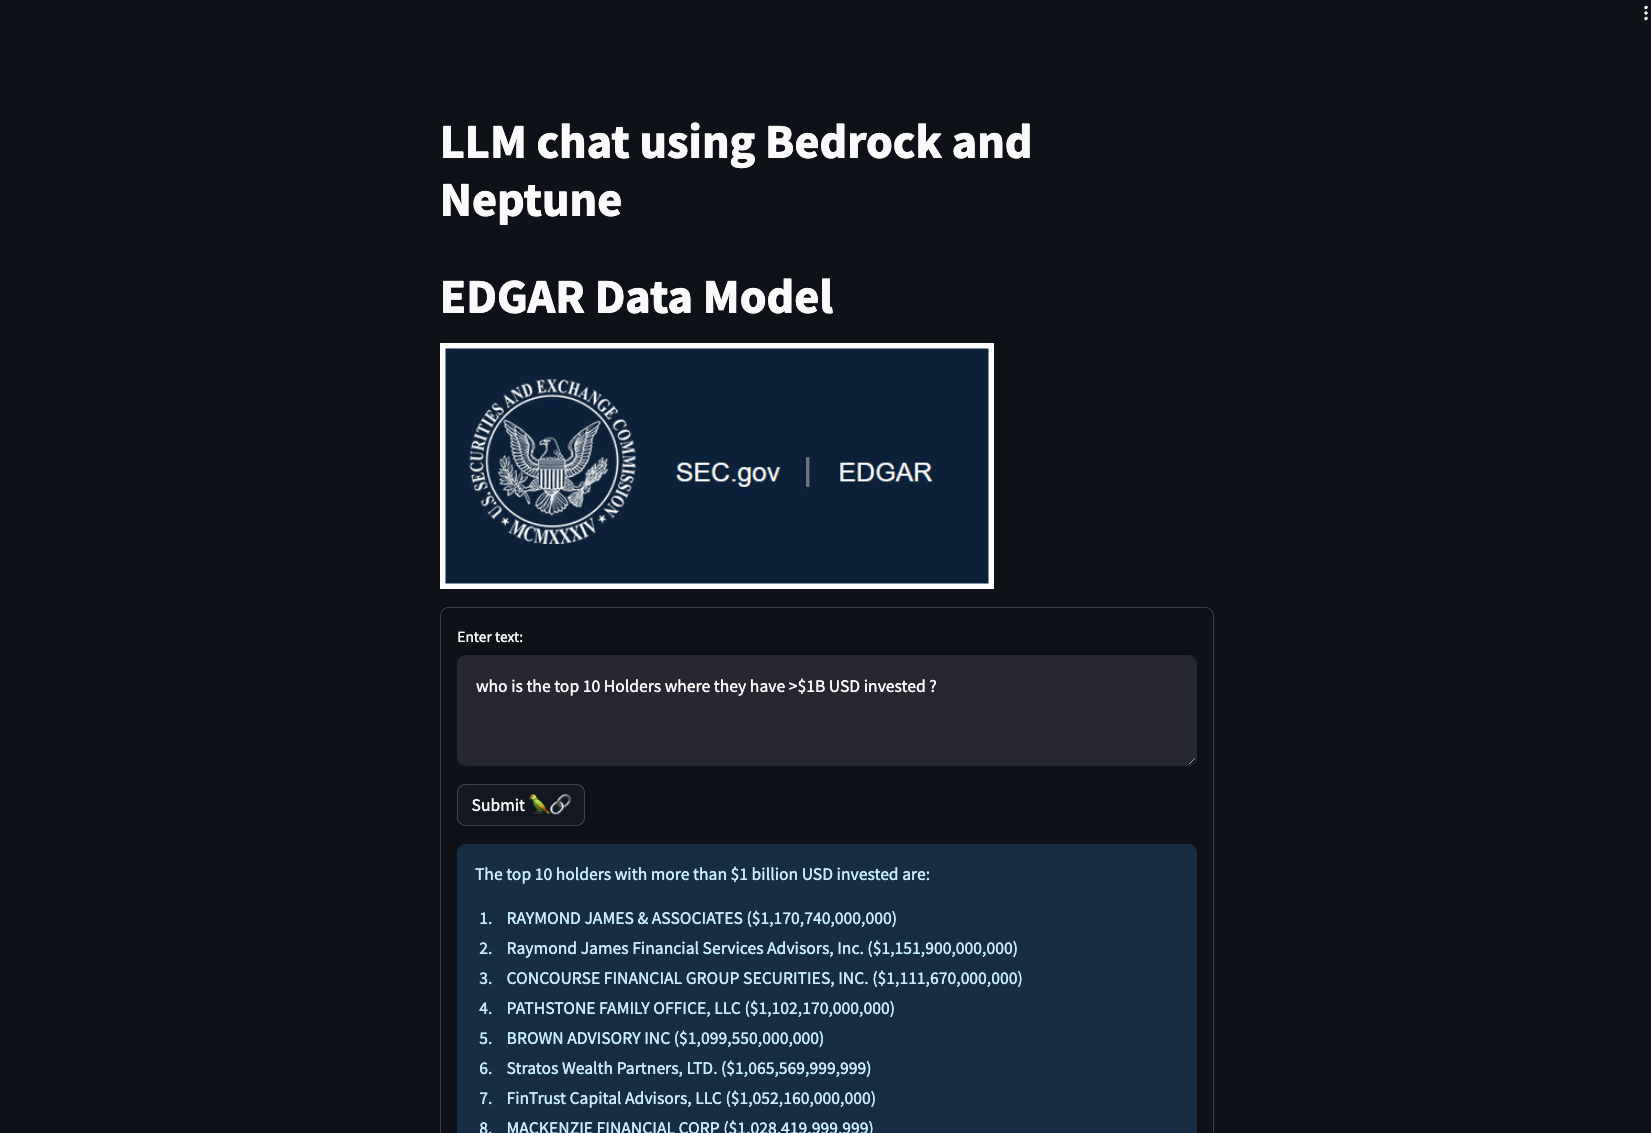



### list of example questions that can be tested with chatbot:
1. who is the top 10 Holder on Quarter 2023Q4 ?
2. who is the top 10 Holders where they have >$1B USD invested ?
3. what top 10 Holdings RAYMOND JAMES & ASSOCIATES owns ?

You can inspect the Python code for the chatbot on this file `DAT107_streamlit_chatbot.py` You can also see the generated `cipher` query on the terminal. 

```python

import streamlit as st
from langchain.graphs import NeptuneGraph
from langchain.llms import Bedrock
from langchain.chains import NeptuneOpenCypherQAChain
from langchain_community.graphs import NeptuneAnalyticsGraph
from langchain.chat_models import BedrockChat

import boto3


bedrock_client = boto3.client('bedrock-runtime')
#get your graph_id first
graph = NeptuneAnalyticsGraph(graph_identifier="g-y5ki4mu2ga")
# connecting to LLM model - model need to be enabled first 
llm = BedrockChat(
    model_id = "anthropic.claude-3-sonnet-20240229-v1:0",
    client = bedrock_client,
    model_kwargs={
        "temperature": 0,
        "top_k": 250,
        "top_p": 1,  
    }
)

extra_info=""" Holder Node represents the business or entity Each Holder node contains name and description attribute The id attribute of the Holder node represents the CIK value which is an SEC assigned identified 
HolderQuarter Node represents the quarter, the name represents the quarter (i.e. 2023Q2) and the id is a combination of the quarter and id value of the Holder Node 
has_holderquarter  Edge represents a fiscal quarter in which the Holder Node had reportable investments this egde connect to HolderQuarter Nodes.  
owns edge represents a security owned by a Holder in a HolderQuarter The edge contains quantity attribute and value attribute, which represents the number and value of the shares owned by the Holder Node in a HolderQuarter.
Holding Node represents the security owned by the Holder Node in the HolderQuarter. Holding Node contains a class attribute, type attribute, and name attribute.
"""

chain = NeptuneOpenCypherQAChain.from_llm(llm=llm, graph=graph,verbose=True,top_K=5,
               return_intermediate_steps=False, return_direct=False)

chain.extra_instructions = extra_info

st.title("LLM chat using Bedrock and Neptune")
st.title("EDGAR Data Model")
st.image('LOGO.jpg', caption='')


def generate_response(input_text):
    st.info(chain.invoke(input_text)['result'])

with st.form('my_form'):
    text = st.text_area('Enter text:', 'who is top 10 Holder on Quarter 2023Q4?')
    submitted = st.form_submit_button('Submit')
    generate_response(text)

```